In [2]:
import pandas as pd
nifty_1day = pd.read_csv('../nifty_daily_continous.csv')
nifty_1day['datetime'] = pd.to_datetime(
    nifty_1day['datetime'], infer_datetime_format=True)
nifty_1day = nifty_1day.set_index("datetime")
nifty_1day = nifty_1day[nifty_1day.index >= '2011-01-03']
nifty_1day["pct_returns"] = nifty_1day["close"].pct_change()
nifty_1day["abs_returns"] = nifty_1day["close"].diff()
nifty_1day['cumsum'] = nifty_1day['abs_returns'].cumsum()
nifty_1day["cumulative_returns"] = (
    (1 + nifty_1day["pct_returns"]).cumprod() - 1)+1
nifty_1day["pct_returns"] = nifty_1day["pct_returns"] * 100


2011-02-22, Close, 5469.20
2011-02-22, BUY CREATE, 5469.20
2011-02-23, BUY EXECUTED, Price: 5452.45, Cost: 5452.45, Comm 0.00
2011-02-23, Close, 5437.35
2011-02-24, Close, 5262.70
2011-02-24, SELL CREATE, 5262.70
2011-02-25, SELL EXECUTED, Price: 5321.05, Cost: 5452.45, Comm 0.00
2011-02-25, OPERATION PROFIT, GROSS -131.40, NET -131.40
2011-02-25, Close, 5303.55
2011-02-28, Close, 5333.25
2011-03-01, Close, 5522.30
2011-03-01, BUY CREATE, 5522.30
2011-03-03, BUY EXECUTED, Price: 5478.45, Cost: 5478.45, Comm 0.00
2011-03-03, Close, 5536.20
2011-03-04, Close, 5538.75
2011-03-07, Close, 5463.15
2011-03-08, Close, 5520.80
2011-03-09, Close, 5531.00
2011-03-10, Close, 5494.40
2011-03-11, Close, 5445.45
2011-03-11, SELL CREATE, 5445.45
2011-03-14, SELL EXECUTED, Price: 5436.50, Cost: 5478.45, Comm 0.00
2011-03-14, OPERATION PROFIT, GROSS -41.95, NET -41.95
2011-03-14, Close, 5531.50
2011-03-14, BUY CREATE, 5531.50
2011-03-15, BUY EXECUTED, Price: 5420.00, Cost: 5420.00, Comm 0.00
2011-03-15,

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


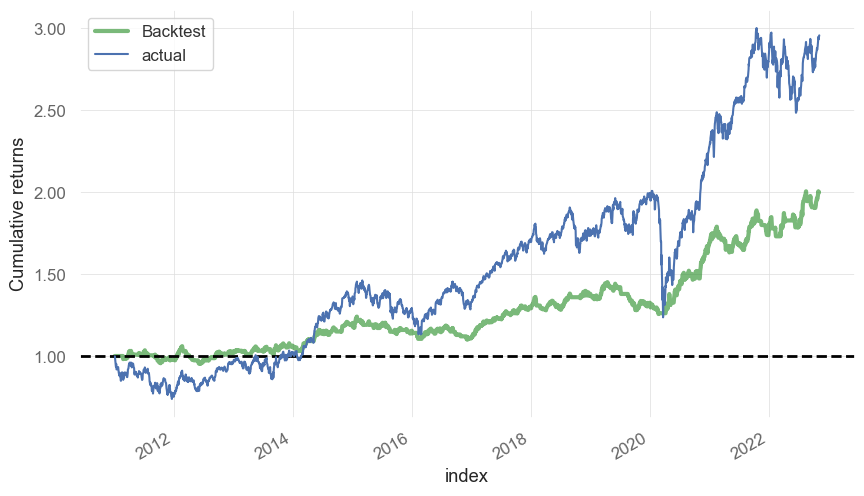

In [11]:
import pandas as pd
import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import quantstats as qs
import pyfolio as pf
import streamlit as st
import seaborn as sns


class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order is not None:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')

data = bt.feeds.YahooFinanceCSVData(
    dataname='../nifty_daily_continous.csv',
    # Do not pass values before this date
    fromdate=datetime.datetime(2011, 1, 3),
    # Do not pass values before this date
    todate=datetime.datetime(2022, 11, 7),
    # Do not pass values after this date
    reverse=False)
cerebro.adddata(data)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]


portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='Nifty Sentiment')

# Plot the cumulative sum using Pyfolio
pf.plotting.plot_rolling_returns(returns)
plt.plot(nifty_1day['cumulative_returns'], label='actual')
plt.legend()
plt.savefig("actual_vs_strategy.png")


## Monte Carlo Simulation


In [12]:
returns = pd.DataFrame({'datetime': returns.index, 'pnl': returns.values})

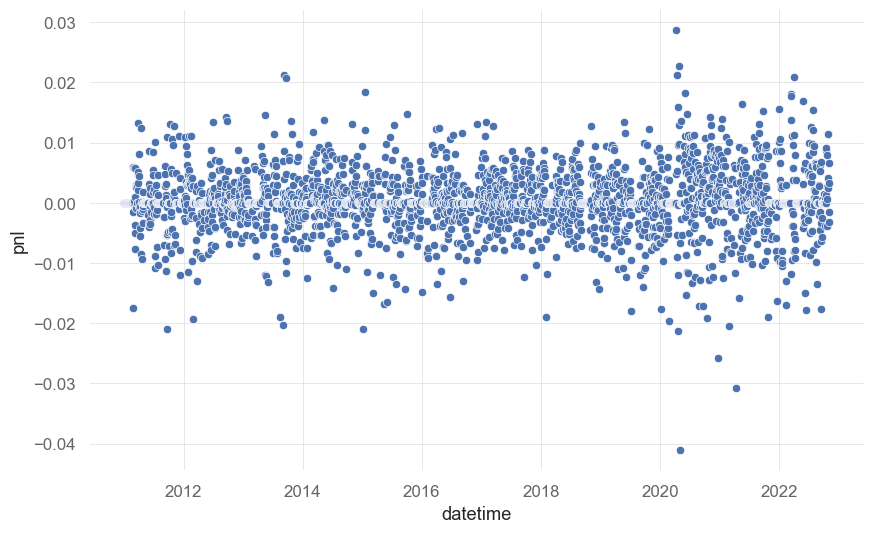

In [14]:
import seaborn as sns
sns.scatterplot(x=returns['datetime'], y=returns['pnl'])

In [15]:
def calc_max_dd(data_series):
    '''
    Inputs:
    data_series (pd.Series): A series of percentage returns of the strategy
    Returns:
    Maximum Drawdown (float)
    '''
    cumm_ret = data_series.cumsum()

    hwm = cumm_ret.cummax()
    dd = cumm_ret-hwm
    return round(dd.min(), 2)


In [18]:
def monte_carlo(simulations, df):
      mdd_list = []
      for s in range(simulations):
        mdd=0
        reshuffle=df['pnl'].sample(frac=1).reset_index(drop=True)
        plt.plot(reshuffle.cumsum())
        mdd=calc_max_dd(reshuffle)
        mdd_list.append(mdd)
      plt.plot(df['pnl'].cumsum(),linewidth=3,color='black')
      plt.xlabel('Trade No.')
      plt.ylabel('Cummulative Returns')
      plt.title('Monte Carlo Simulation for {} Simulations'.format(simulations))
      plt.show()
      return mdd_list

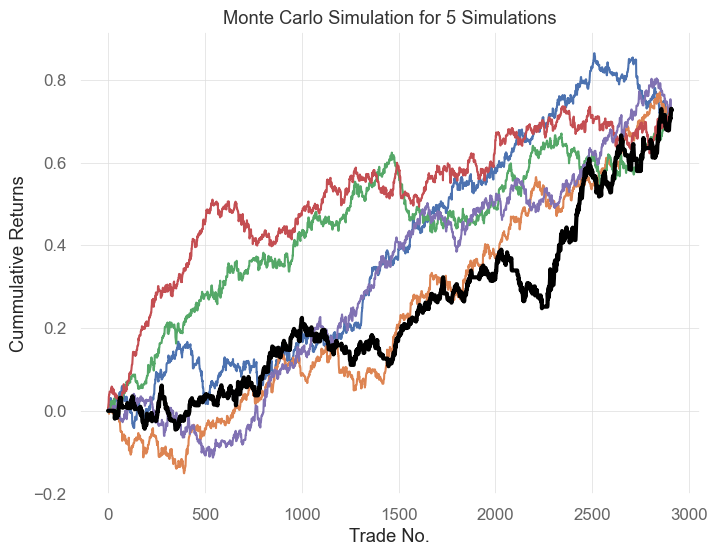

In [19]:
simulations = 5
plt.figure(figsize=(8, 6))
mdd_list = monte_carlo(simulations, returns)

In [20]:
mdd_list

[-0.15, -0.16, -0.19, -0.11, -0.15]

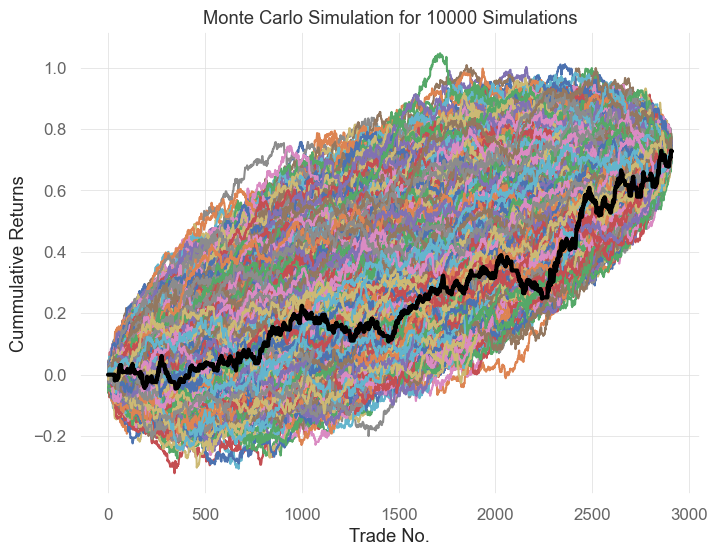

In [22]:
simulations = 10000
plt.figure(figsize=(8, 6))
mdd_list = monte_carlo(simulations, returns)

In [23]:
df_mdd = pd.DataFrame(mdd_list, columns=['Max DD'])

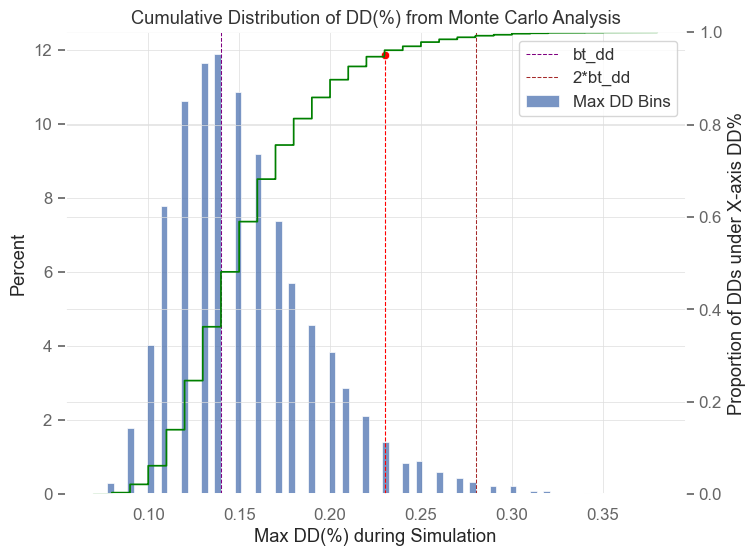

Backtest Drawdown: -0.14% , The 95.0 percentile of the Drawdown based on Monte Carlo is:0.23%


In [25]:
import numpy as np
n_tile = 0.95  # Cut-Off Percentile to plot
n_tile_value = np.round(df_mdd['Max DD'].quantile(q=1-n_tile), 2)
bt_dd = calc_max_dd(returns['pnl'])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(ax=ax, x=-1*df_mdd['Max DD'], stat='percent')  # ,cumulative=True)
ax.set_title('Cumulative Distribution of DD(%) from Monte Carlo Analysis')
ax.set_xlabel('Max DD(%) during Simulation')
ax.axvline(-bt_dd, ymax=1, color='purple', linestyle='dashed', linewidth=0.75)
ax.axvline(-2*bt_dd, ymax=1, color='brown', linestyle='dashed', linewidth=0.75)
ax.legend(labels=['bt_dd', '2*bt_dd', 'Max DD Bins'])
ax2 = ax.twinx()
sns.ecdfplot(ax=ax2, x=-1*df_mdd['Max DD'], color='green', linewidth=1.25)
sns.scatterplot(x=[-1*n_tile_value], y=[n_tile], ax=ax2, color='red')
ax2.axvline(-1*n_tile_value, ymax=n_tile, color='red',
            linestyle='dashed', linewidth=0.8)
ax2.set_ylabel('Proportion of DDs under X-axis DD%')
plt.show()
print(
    f'Backtest Drawdown: {bt_dd}% , The {n_tile*100} percentile of the Drawdown based on Monte Carlo is:{-1*n_tile_value}%')